# Download data to Colab

This notebook shows how to download the hackathon data to the Colab drive.


In [2]:
import os
import h5py
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

In [6]:
labels = read_csv("../data/train_gold.tsv", delimiter="\t", index_col=0, names=["reference"])

print(labels.head(5))

with h5py.File("../data/train.h5") as f:
    assert(labels.shape[0] == f["id"].shape[0])
    assert(labels.shape[0] == f["img"].shape[0])
    assert(labels.shape[0] == f["shape"].shape[0])
    assert(labels.index.isin(np.asarray(f["id"])).all())
  
print('Dataset info is OK')


        reference
1655573  posible,
1655574      Jose
1655575        de
1655576   OFICINA
1655577        Gu
Dataset info is OK


In [8]:
f = h5py.File('../data/train.h5')

def show_image(i):
    ids = f['id']
    imgs = f['img']
    shapes = f['shape']
    shape = shapes[i]
    block_len = int(shape[0]) * int(shape[1])  # number of pixels
    block_bits = imgs[i]            # get packed bits
    block_pixels = np.unpackbits(block_bits)         # unpack bits into boolean pixels
    block_pixels = block_pixels[:block_len]          # discard trailing bits generate during packing
    block_array = np.reshape(block_pixels, shape)
    plt.imshow(block_array)
    plt.title('id: {}, target: {}'.format(ids[i], labels.reference.values[i]))
    plt.show()
    return

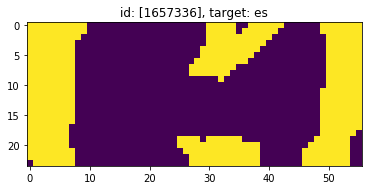

In [12]:
show_image(1245)

In [0]:
"""
with h5py.File('./train.h5') as f:
    ids = f['id']
    imgs = f['img']
    shapes = f['shape']
    for i in range(ids.shape[0])[:10]:
        shape = shapes[i]
        block_len = int(shape[0]) * int(shape[1])  # number of pixels
        block_bits = imgs[i]            # get packed bits
        block_pixels = np.unpackbits(block_bits)         # unpack bits into boolean pixels
        block_pixels = block_pixels[:block_len]          # discard trailing bits generate during packing
        block_array = np.reshape(block_pixels, shape)
        plt.imshow(block_array)
        plt.title('id: {}, target: {}'.format(ids[i], labels.reference.values[i]))
        plt.show()
"""

"\nwith h5py.File('./train.h5') as f:\n    ids = f['id']\n    imgs = f['img']\n    shapes = f['shape']\n    for i in range(ids.shape[0])[:10]:\n        shape = shapes[i]\n        block_len = int(shape[0]) * int(shape[1])  # number of pixels\n        block_bits = imgs[i]            # get packed bits\n        block_pixels = np.unpackbits(block_bits)         # unpack bits into boolean pixels\n        block_pixels = block_pixels[:block_len]          # discard trailing bits generate during packing\n        block_array = np.reshape(block_pixels, shape)\n        plt.imshow(block_array)\n        plt.title('id: {}, target: {}'.format(ids[i], labels.reference.values[i]))\n        plt.show()\n"

In [15]:
labels.head()

,reference
1655573,"posible,"
1655574,Jose
1655575,de
1655576,OFICINA
1655577,Gu


In [16]:
# Determine unique labels + eos
long_string = ""
for i in tqdm(labels.reference.values):
    long_string += i
long_string = list(long_string)
long_string.insert(0, "<eos>")
long_string.insert(0, "<sos>")
long_string.insert(0, "<pad>")
my_labels, counts = np.unique(long_string, return_counts=True)

100%|█████████████████████████████████████████████████████████████████████| 6953406/6953406 [05:16<00:00, 21989.89it/s]


In [18]:
# Encoder
char2idx = {u:i for i, u in enumerate(my_labels)}
idx2char = np.array(my_labels)

np.save("../data/processed/char2idx.npy", char2idx)
np.save("../data/processed/idx2char.npy", idx2char)

In [19]:
# Add eos and sos to labels datframe
encoded_labels = []
seq_len = []
for lab in tqdm(labels.reference.values):
    encoded = [char2idx[i] for i in list(lab)]
    seq_len.append(len(encoded))
    encoded.append(char2idx["<eos>"])
    encoded.insert(0, char2idx["<sos>"])
    encoded_labels.append(encoded)
labels["seq_len"] = seq_len
labels["encoded_labels"] = encoded_labels

100%|████████████████████████████████████████████████████████████████████| 6953406/6953406 [00:15<00:00, 440741.37it/s]


In [60]:
labels.head()

,reference,seq_len,encoded_labels
1655573,"posible,",8,"[29, 77, 76, 80, 70, 63, 73, 66, 10, 27]"
1655574,Jose,4,"[29, 42, 76, 80, 66, 27]"
1655575,de,2,"[29, 65, 66, 27]"
1655576,OFICINA,7,"[29, 47, 38, 41, 35, 41, 46, 33, 27]"
1655577,Gu,2,"[29, 39, 82, 27]"


In [22]:
labels.to_csv("../data/processed/labels.csv")

### select only 10k images for code testing

In [69]:
imgs = f['img']
shapes = f['shape']
N = 100000

In [70]:
mask1 = shapes[:, 0] <= 36
mask2 = shapes[:, 1] <= 72
mask = mask1 * mask2

In [72]:
index = np.arange(len(labels))[mask][:N]
x = np.zeros((N, 36, 72), dtype=np.uint8)
y = np.ones((N, np.max(new_seq_len) + 2), dtype=int) * char2idx["<pad>"]

new_reference = labels.reference.values[mask][:N]
new_encoded_values = labels.encoded_labels.values[mask][:N]
new_seq_len = labels.seq_len.values[mask][:N]

for i, idx in tqdm(enumerate(index)):
    shape = shapes[idx]
    block_len = int(shape[0]) * int(shape[1])  # number of pixels
    block_bits = imgs[idx]            # get packed bits
    block_pixels = np.unpackbits(block_bits)         # unpack bits into boolean pixels
    block_pixels = block_pixels[:block_len]          # discard trailing bits generate during packing
    block_array = np.reshape(block_pixels, shape)
    x[i, :shape[0], :shape[1]] = np.logical_not(block_array)
    y[i, :new_seq_len[i] + 2] = new_encoded_values[i]



0it [00:00, ?it/s]

433it [00:00, 4298.52it/s]

865it [00:00, 4295.17it/s]

1187it [00:00, 3894.19it/s]

1590it [00:00, 3925.20it/s]

2032it [00:00, 4053.44it/s]

2472it [00:00, 4142.96it/s]

2912it [00:00, 4208.41it/s]

3348it [00:00, 4243.28it/s]

3781it [00:00, 4259.57it/s]

4194it [00:01, 4210.53it/s]

4608it [00:01, 4179.93it/s]

5040it [00:01, 4211.96it/s]

5461it [00:01, 4202.14it/s]

5897it [00:01, 4239.65it/s]

6329it [00:01, 4254.24it/s]

6772it [00:01, 4296.32it/s]

7206it [00:01, 4299.50it/s]

7636it [00:01, 4277.96it/s]

8064it [00:01, 4218.84it/s]

8486it [00:02, 3740.93it/s]

8870it [00:02, 3486.16it/s]

9298it [00:02, 3684.61it/s]

9736it [00:02, 3861.07it/s]

10132it [00:02, 3718.18it/s]

10512it [00:02, 3527.30it/s]

10873it [00:02, 3413.41it/s]

11265it [00:02, 3544.05it/s]

11687it [00:02, 3715.56it/s]

12103it [00:03, 3830.85it/s]

12531it [00:03, 3947.37it/s]

12931it [00:03, 3786.43it/s]

13315it [00:03, 3571.85it/s]

13678it [00:03, 3391.30it/s]

14105it [00:0

Text(0.5, 1.0, '[29 65 66 27 28 28 28 28 28 28]')

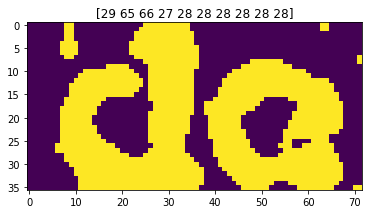

In [73]:
i = 0
plt.imshow(x[i])
plt.title(y[i])

In [74]:
np.save("../data/processed/x.npy", x)
np.save("../data/processed/y.npy", y)

In [75]:
seq_len = (y != 28).sum(-1) - 1

In [76]:
np.save("../data/processed/seq_len.npy", seq_len)

In [79]:
index = np.arange(len(x))
np.random.shuffle(index)

x = x[index]
y = y[index]
seq_len = seq_len[index]

n = int(0.9 * N)

np.save("../data/processed/x_train.npy", x[:n])
np.save("../data/processed/y_train.npy", y[:n])
np.save("../data/processed/seq_len_train.npy", seq_len[:n])

np.save("../data/processed/x_val.npy", x[n:])
np.save("../data/processed/y_val.npy", y[n:])
np.save("../data/processed/seq_len_val.npy", seq_len[n:])